# Introduction

Welcome to this example notebook.

The objective of this notebook is to use a publicly available to illustrate the main steps of the analysis pipeline.

You can either 
- **browse the already computed notebook**, which includes the output of the cells,
- Or **clear all outputs and compute along**

If you wish to compute along, you will need :
- a python environment with jupyter lab enabled
- the IRkernel package installed in R, and run the R command : IRkernel::installspec()
- Installing all the packages, specified in the install.r file (available here : https://github.com/BorisLerais/SpatialExperiment-analysis/blob/main/install.r)
- 16 GB of RAM or more is recommended

In [1]:
library(SpatialDatasets)
library(imcRtools)
library(tidyverse)
library(viridis)
library(RColorBrewer)

Le chargement a nécessité le package : ExperimentHub

Le chargement a nécessité le package : BiocGenerics


Attachement du package : 'BiocGenerics'


Les objets suivants sont masqués depuis 'package:stats':

    IQR, mad, sd, var, xtabs


Les objets suivants sont masqués depuis 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Le chargement a nécessité le package : AnnotationHub

Le chargement a nécessité le package : BiocFileCache

Le chargement a nécessité le package : dbplyr

Le chargement a nécessité le package : SpatialExperiment

Le chargement a nécessité le package : SingleCellExperiment

Le chargement a nécessité 

In [ ]:
# This pipeline defines its function in a separate script for increase clarity
# We source the function at the start of each notebook
# This uses the functions.r file available on my github
source("https://raw.githubusercontent.com/BorisLerais/SpatialExperiment-analysis/refs/heads/main/functions.r")

In [3]:
# To reproduce the same result, we will fix a seed
seed <- 42
set.seed(seed)

# Loading the dataset

We will use **spe_Ferguson_2022** to illustrate this notebook. This publicly available data set was used to describe the immune microenvironment in Cutaneous Squamous Cell Carcinoma, using an imaging technology called Imaging Mass Cytometry (IMC), which combines a laser vaporizing 1µm² of tissue with Mass cytometry (cyTOF) to allow spatially resolved quantification of metal-marked antibody. 

In this example, the authors use a panel of 36 markers (including 2 DNA channels) to explore the microenvironment of 44 samples of tumors, coming from 17 patients, and comparing patients that experienced tumor progression (group = P) and those that did not (group = NP) after treatment by immune checkpoint inhibitors.


For more detail about the experimental design, please refer to the original publication : 
Angela L. Ferguson, Ashleigh R. Sharman, Ruth O. Allen, Thomas Ye, Jenny H. Lee, Tsu-Hui H. Low, Sydney Ch'ng, Carsten E. Palme, Bruce Ashford, Marie Ranson, Jonathan R. Clark, Ellis Patrick, Ruta Gupta, Umaimainthan Palendira; High-Dimensional and Spatial Analysis Reveals Immune Landscape–Dependent Progression in Cutaneous Squamous Cell Carcinoma. Clin Cancer Res 1 November 2022; 28 (21): 4677–4688. https://doi.org/10.1158/1078-0432.CCR-22-1332

In [4]:
# Angela L. Ferguson, et al.,
# High-Dimensional and Spatial Analysis Reveals Immune Landscape–Dependent Progression in Cutaneous Squamous Cell Carcinoma. 
# Clin Cancer Res 1 November 2022; 28 (21): 4677–4688.
# https://doi.org/10.1158/1078-0432.CCR-22-1332
spe <- SpatialDatasets::spe_Ferguson_2022()
# base 155913 cells

see ?SpatialDatasets and browseVignettes('SpatialDatasets') for documentation

loading from cache



In [5]:
# small adaptation are needed to make this object operable :
# Which would otherwise be dealt with while preparing the data
colnames(spe) <- paste0("cell", seq_len(ncol(spe)))
spe$patientID <- as.factor(spe$patientID)
spe$sample_id <- as.factor(spe$sample_id)
spe$group <- as.factor(spe$group)

# Data preprocessing


The preprocessing stage includes 2 steps :

- The first step is to transform the to limit the skewedness of the data. For IMC, typical transformation uses asinh with a cofactor of 1
- Dimension reduction including PCA, UMAP and if needed batch-effect correction via integration (illustrated here with harmony)

## Defining parameters

This pipeline uses a special framework of parameters that record the parameters used for function called. <br>
By prompting the parameters to set, this enables user with little R background to follow along the pipeline.

In [6]:
# First set some global_parameters which apply to all functions
# For example, in this interactive notebook,
# we will prefer to display the plots rather than storing them on disk
global_parameters(spe) <- list(
  store_plot = FALSE,
  seed = 42, #for RNG control
  quiet = FALSE, # displays additional messages,
  patient_id = "patientID" # adapting to the name
)

In [7]:
# Some parameters specific to preprocessing :

# transform method and transform parameter control the data transformation
# The new assay will be stored under "transfromed_name"

# downsampling will be used to speed up the example by only takin 10% of cells

# plot_transformation will also plot quality control at the same time

# Integration controls wether a integration is done on top
parameters(spe, "preprocessing") <- list(
  assay_name = "counts", #Name of the base assay
  transform_method = "asinh", #Available : asinh, log, roots, standard
  transform_parameter = 1,
  transformed_name = "asinh_transformed",
  downsampling = 0.1,
  plot_transformation = TRUE,
  downsample_plot = 0.1, #Ratio to downsample the plots
  integration = "harmony",
  group_by = "sample_id" # groups for integration
)

## Performing preprocessing task

Expected computation time ~ 1 min.

In [8]:
# The function preprocess_data will perform all these task
# It can retrieve its arguments from the previously set parameters
spe <- preprocess_data(spe, param_name = "preprocessing")

Subsampling

Transforming assay

Preparing variables

Preparing mapper

Preparing list of plots

Building PCA

Warning message in check_numbers(x, k = k, nu = nu, nv = nv):
"more singular values/vectors requested than available"
Building UMAP

Integrating with Harmony

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Building UMAP from Harmony



In [9]:
reducedDimNames(spe)

[1] "PCA"                    "UMAP"                   "HARMONY"               
[4] "UMAP_harmony_corrected"

## Visualizing marker distribution

Now that the computation is over, we can proceed to visualization.

Since we specified store_plot = FALSE (in the global_parameters), the generated plots are stored in the metadata of spe, but a typical pipeline might prefer to store them on disk to review later.

Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


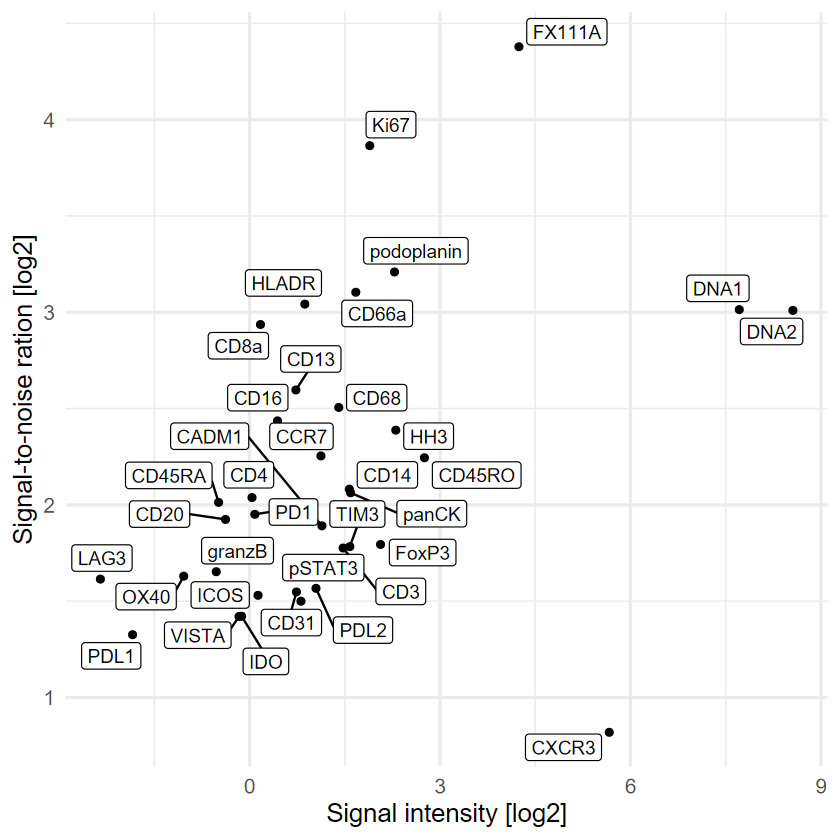

In [10]:
# This plot represent the signal-to-noise ratio in function of the intensity
# marker at the bottom of the plot have a lower ratio, making it
# harder to discriminate between positive and negative cells
get_metadata(
  spe,
  category = "transformation",
  name = "asinh_1",
  type = "snr_plot"
)

# Here most of the marker have globally a good performance after transformation
# Except CXCR3, which has a snr < 2 (NB : log2 y scale)

Picking joint bandwidth of 0.152

Picking joint bandwidth of 0.165



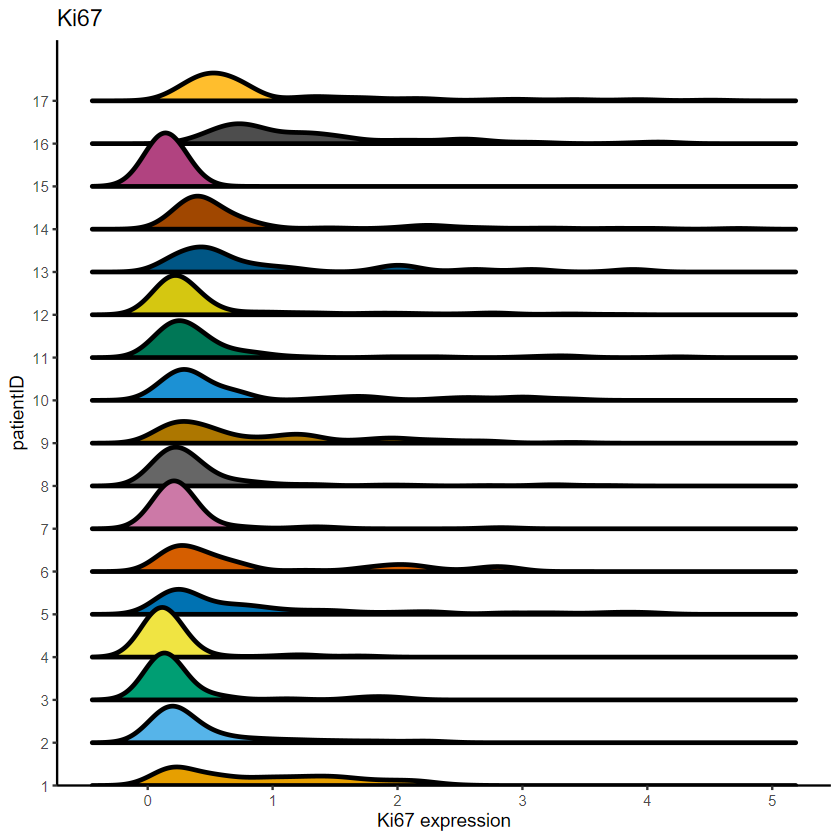

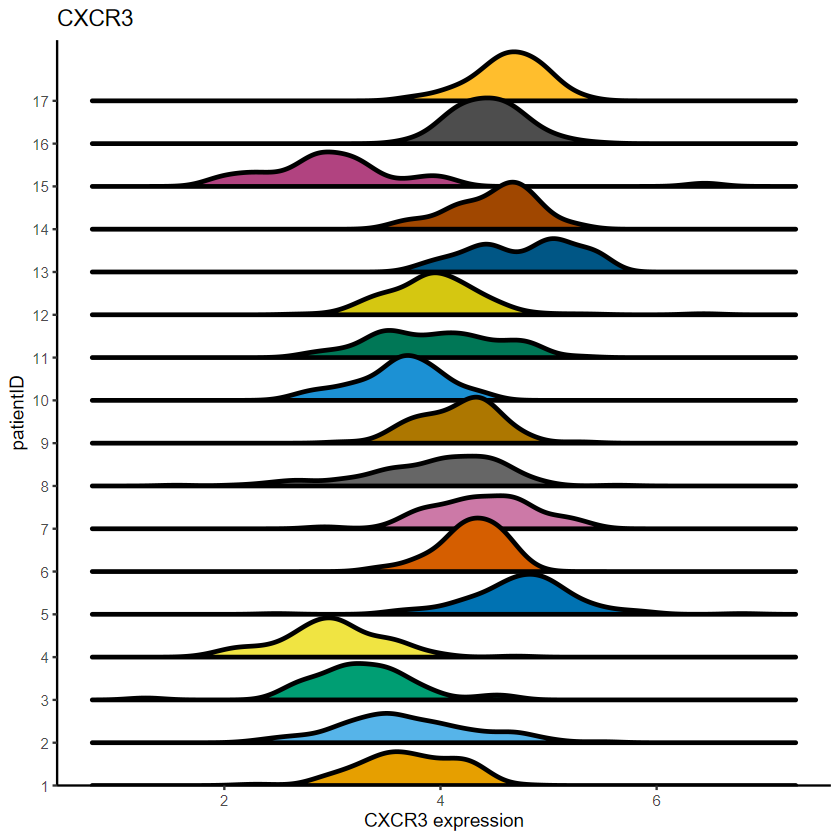

In [11]:
# These plots allow visualization of the distribution of marker intensity
# Example of a good marker : Ki67, showing a double distribution
get_metadata(
  spe,
  category = "transformation",
  name = "asinh_1",
  type = "Ki67"
)

# CXCR3 seems to be globally right shifted, and heterogenous across samples
# It is likely that it experiences high background noise
# Excluding it from the analysis might be advisable
get_metadata(
  spe,
  category = "transformation",
  name = "asinh_1",
  type = "CXCR3"
)

## Visualizing dimension reduction and integration

We may also wish to visualize the shape of the data using UMAP projection.

$UMAP

$UMAP_harmony_corrected


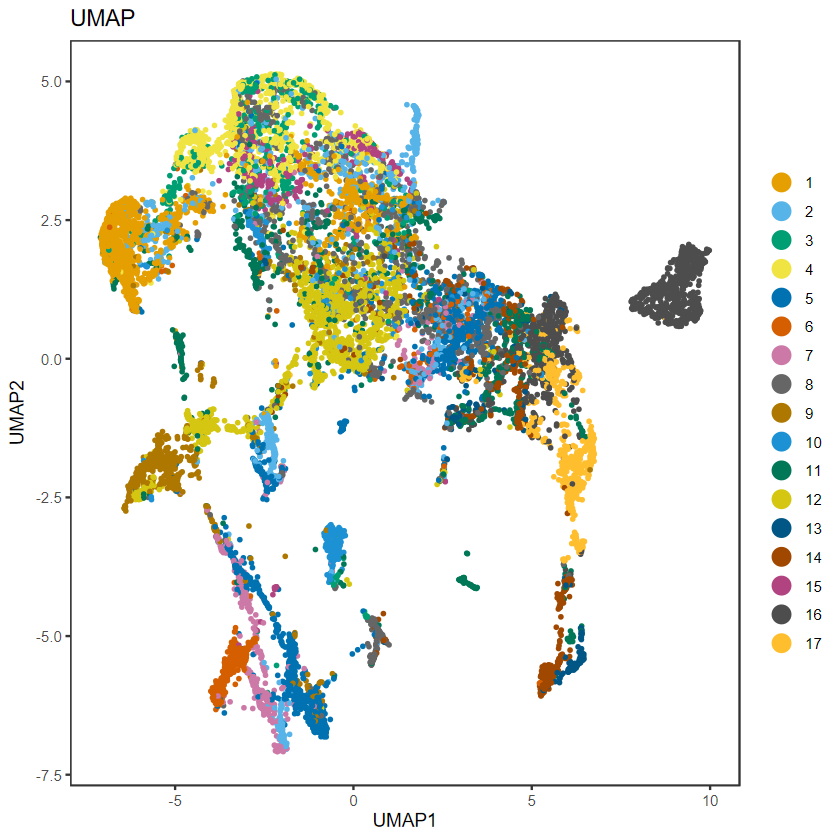

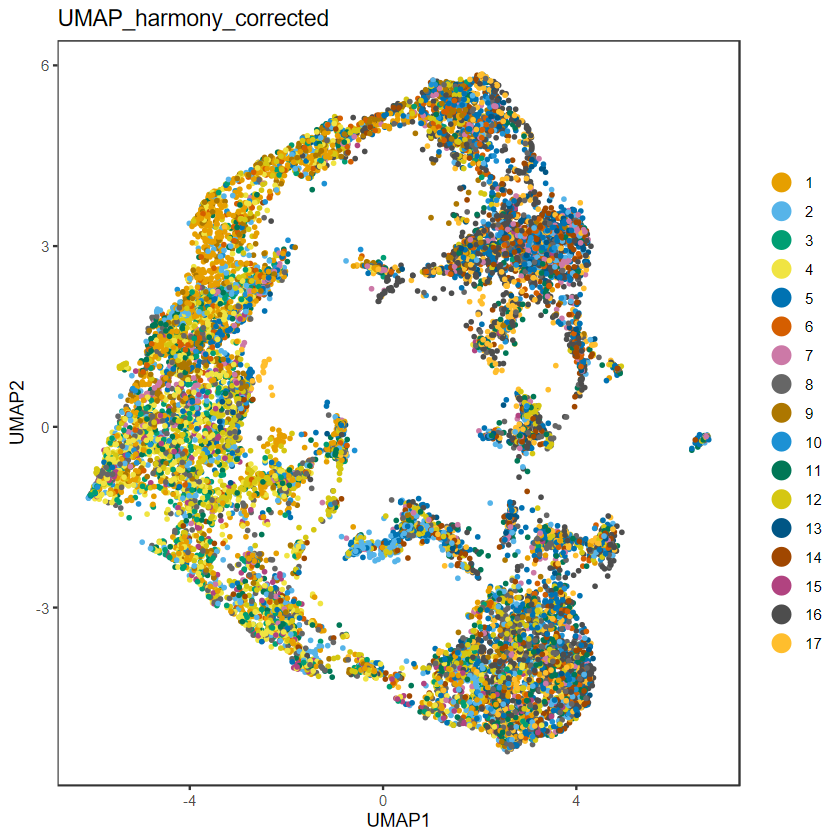

In [12]:
# We will use our function, plot_umap to project patientID
# On the unintegrated and the integrated UMAP
plot_umap(
  spe,
  by = "reducedDim",
  select = c("UMAP", "UMAP_harmony_corrected"),
  reducedDim_col = "patientID"
)

# We can see that there is the overlap on the uncorrected UMAP is poor
# Indicative of technical differences between the samples
# Of course, review of the image would be necessary to confirm
# what part of the difference is technical, and what part may be biological
# Harmony Integration allowed much better overlap

# Benchmarking clustering

Now that we pre-processed the data, we can move on to clustering. We will likely need to try a few combination of parameters before we can decide which clustering is satisfactory.

We provide an integrated benchmark_clustering function to do just that. First, let's decide on some parameters

## Prepare the channel to use

In [13]:
# Remove the DNA channels from the downstream analysis
# It may also be usefull to remove dubious marker such as CXCR3
use_channel <- !rownames(spe) %in% c("DNA1", "DNA2")
# We will add this vector to the rowData,
# which contains information on the markers
rowData(spe)$use_channel <- use_channel

## cluster parameters

The key clustering parameters are :
- `dim_red_for_clusters` : Which dimension reduction to use for clustering (either "none" or a reducedDim). Typically used to contruct cluster from harmony or other integration.
- `cluster_method` : most notably flowsom (self-organizing map based) or louvain (graph-based, often called PhenoGraph based on a notable publication featuring it - Levine et al. 2015)
- `xdim` and `ydim` : for flowSOM, the number of initial grid dimension
- `max_k` : for flowSOM, the max number of metacluster (will build from 2 to max_k)
- `louvain_parameter` : for louvain, the k number of neighbor
- `weight_type_parameter` : for louvain, the type of graph edge optimisation. Default is "jaccard", similar to what is used in PhenoGraph publication (Levine et al. 2015) or in the Seurat package

For the sake of simplicity and brevity, we will demonstrate testing only two dim_red_for_clusters and two cluster_method, fixing the other parameters

In [14]:
# Prepare two lists, containing : 
# The varying parameters
benched_param <- list(
  cluster_method = c(rep_len("louvain", 2), rep_len("flowsom", 2)),
  dim_red_for_clusters = c(rep_len(c("none", "HARMONY"), 4)),
  benched_names = c(
    "louvain_none_jaccard_10",
    "louvain_harmony_jaccard_10",
    "flowsom_none_10x10",
    "flowsom_harmony_10x10"
  )
)

# The constant parameters
common_parameters <- list(
  xdim = 10,
  ydim = 10,
  max_k = 20,
  louvain_parameter = 10,
  weight_type_parameter = "jaccard"
)

## Benchmark clustering

Benchmark_clustering will :
- Create sets of parameters based on provided benched_parameters
- Perform clustering and metaclustering if needed
- Create associated plots (available : heatmap, violin and umap)
- Since store_plot is FALSE, the plots will be available in the metadata (benchmark_plots category)

In [15]:
global_parameters(spe) <- list(
  use_channel = use_channel,
  assay_name = "asinh_transformed"
)

parameters(spe, "expr_plots") <- list(assay_name = "asinh_transformed")

parameters(spe, "benchmarking") <- list(
  skip_preprocess = TRUE, #already done
  benched_names = benched_param$benched_names,
  benched_param = benched_param,
  common_param = common_parameters,
  get_plots = c("heatmap", "violin"),
  plot_param = "expr_plots"
)

parameters(spe, "expr_plots") <- list(assay_name = "asinh_transformed")

## Execution :

Estimated computation time : ~ 30 sec

In [16]:
spe <- benchmark_clustering(spe, "benchmarking")

Preparing benchmark parameters

Clustering

Running louvain_none_jaccard_10


Running louvain_harmony_jaccard_10


Building FlowSOM tree : flowsom_none_10x10.

Metaclustering :flowsom_none_10x10.

Checking arguments. 


Building matrix for :flowsom_none_10x10.

Aggregating cluster : flowsom_none_10x10.

Metaclustering : flowsom_none_10x10.

Storing metaclusters for :flowsom_none_10x10.

Metaclustering done :flowsom_none_10x10.

Building FlowSOM tree : flowsom_harmony_10x10.

Metaclustering :flowsom_harmony_10x10.

Checking arguments. 


Building matrix for :flowsom_harmony_10x10.

Aggregating cluster : flowsom_harmony_10x10.

Metaclustering : flowsom_harmony_10x10.

Storing metaclusters for :flowsom_harmony_10x10.

Metaclustering done :flowsom_harmony_10x10.

Plotting

Computing expression values

Preparing plots

Preparing variables

Preparing mapper

Preparing list of plots

Preparing variables

Preparing mapper

Preparing list of plots

Preparing variables

Preparing mapper

Prepari

# Visualizing clustering

The benchmark_clustering will have prepared multiple clustering, which are stored in the colData of spe, as well as multiple plots

## Visualizing louvain

In [17]:
# benchmark_clustering will have prepare some plot for us, 
# namely heatmap and violin plots

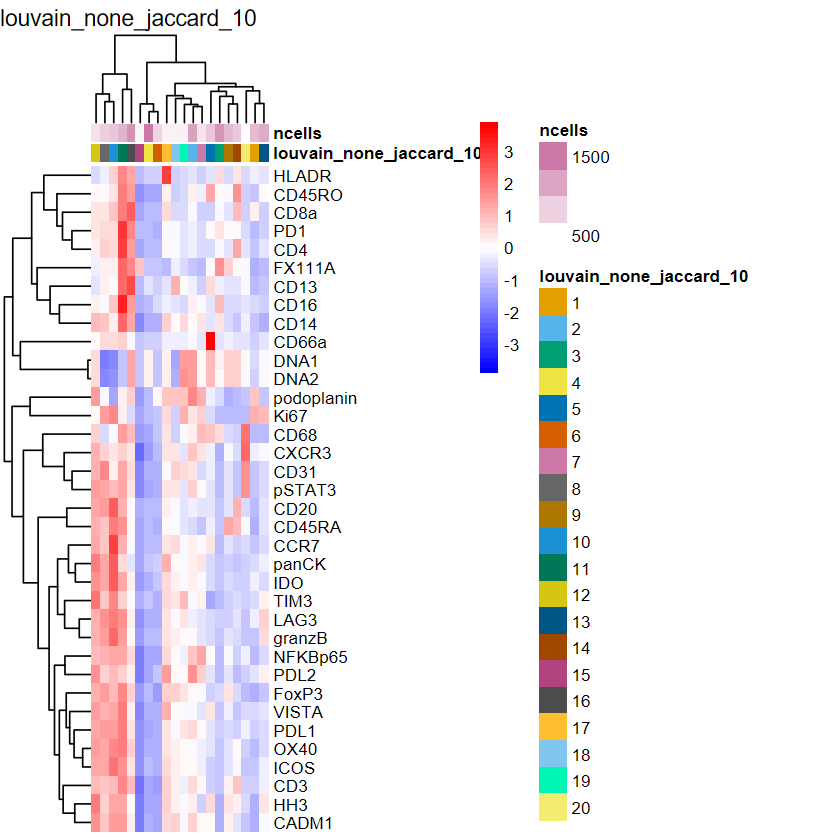

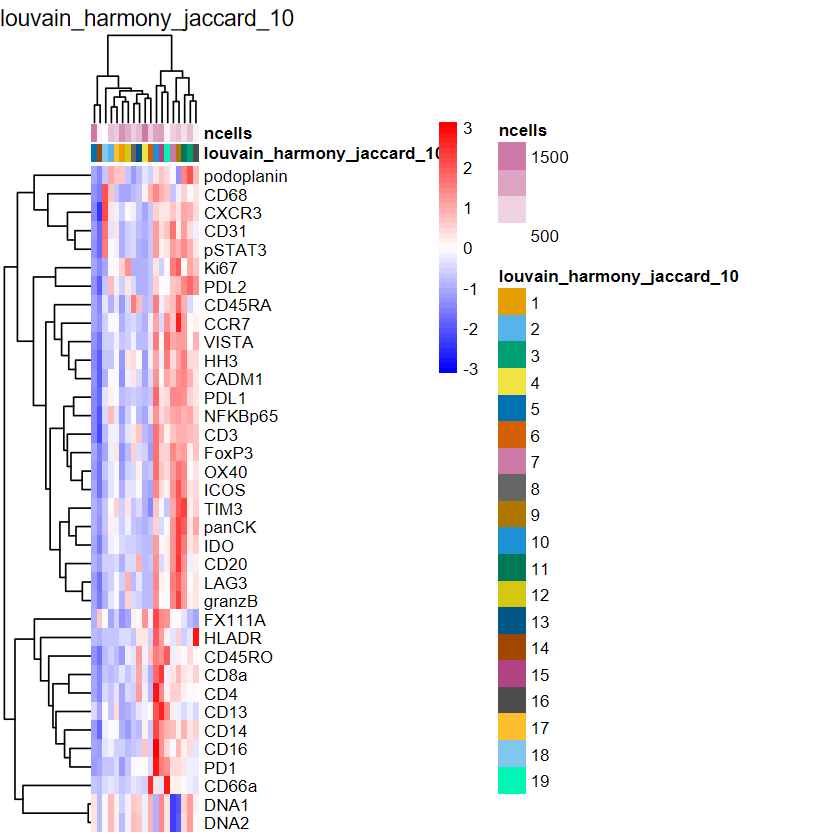

In [19]:
# We can first review the heatmaps :
get_metadata(spe, "benchmark_plots", "louvain_none_jaccard_10", "heatmap")
get_metadata(spe, "benchmark_plots", "louvain_harmony_jaccard_10", "heatmap")

# Since results are similar, we will only show harmony hereafter

[[1]]

[[2]]


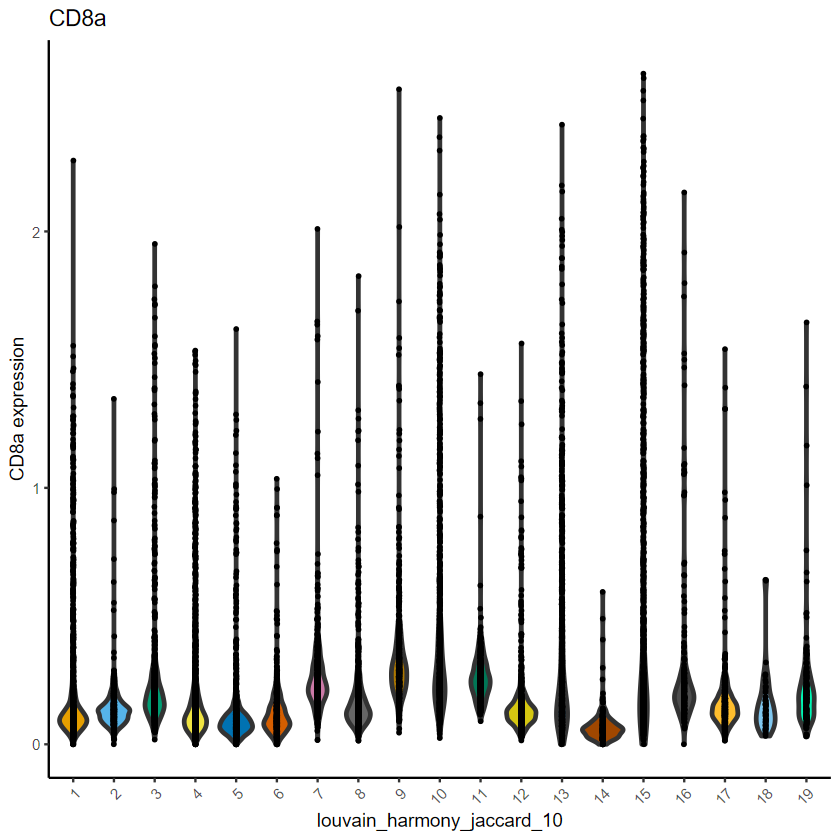

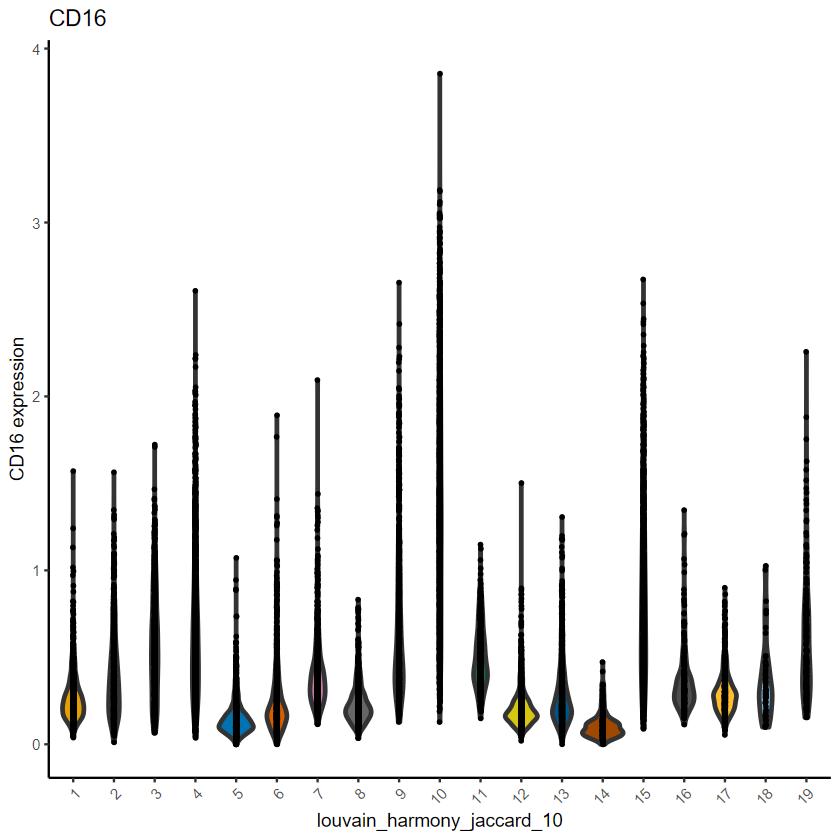

In [ ]:
# On the heatmap, for harmony
# We can see for example 2 clusters of CD8 T cells,
# But they also show high expresion of macrophage markers
# We can use the violin plot to visualize the heterogeneity of the intensity

get_metadata(spe, "benchmark_plots", "louvain_harmony_jaccard_10", "violin")[c(5, 7)]

## Visualizing Flowsom

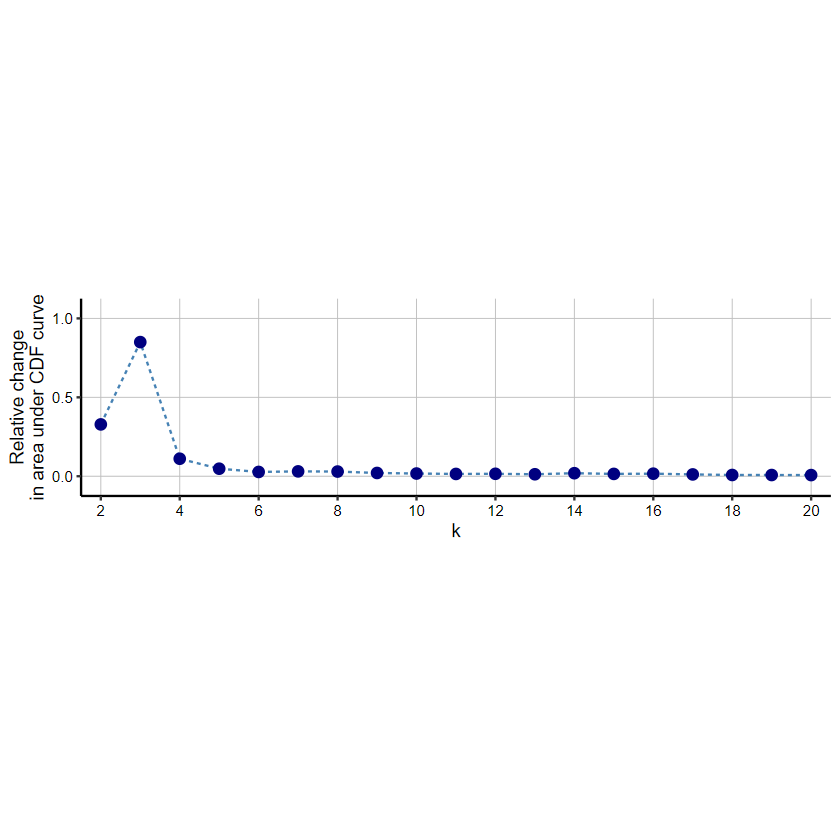

In [ ]:
# Flowsom is a bit different, as it requires metaclustering
# While metaclustering has been done during benchmark, we still need to choose
# a k value, number of metaclusters
# We can use delta_plot to visualize the stability of the clustering :

get_metadata(
  spe,
  "metaclustering",
  "flowsom_harmony_10x10",
  type = "delta_area"
)
# When the line joins 0, increasing the k does not
# significantly increase the stability
# Here we could use a k = 10

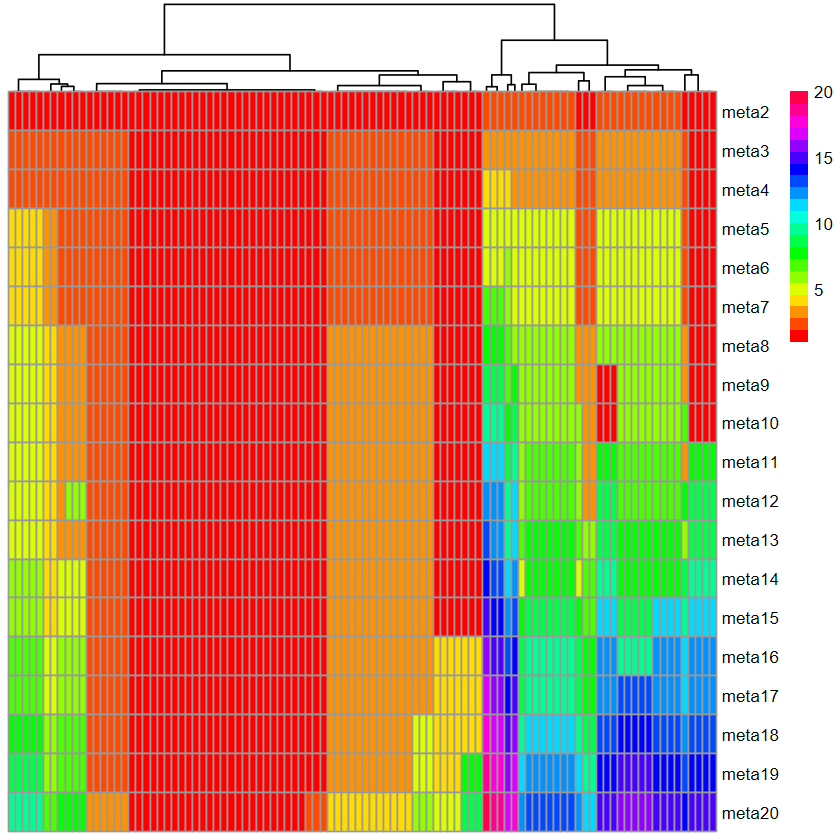

In [ ]:
# We can also use the cluster tracker to see 
# which metacluster change as we increase k
# We see here that increasing k will not 
# separate the main bloc (metacluster 1) beyond k = 10
plot_cluster_tracker(
  spe,
  "flowsom_harmony_10x10"
)

In [29]:
# We can thus decide to translate with k = 10 :
# Which adds a colData while translating the clusters into metaclusters
spe <- store_translation(
  spe,
  "flowsom_harmony_10x10",
  k = 10
)

In [ ]:
# Now we can visualize the heatmap
plot_list <- plot_expr_heatmap(
  spe,
  select = "flowsom_harmony_10x10_10"
)

Computing expression values

Preparing plots



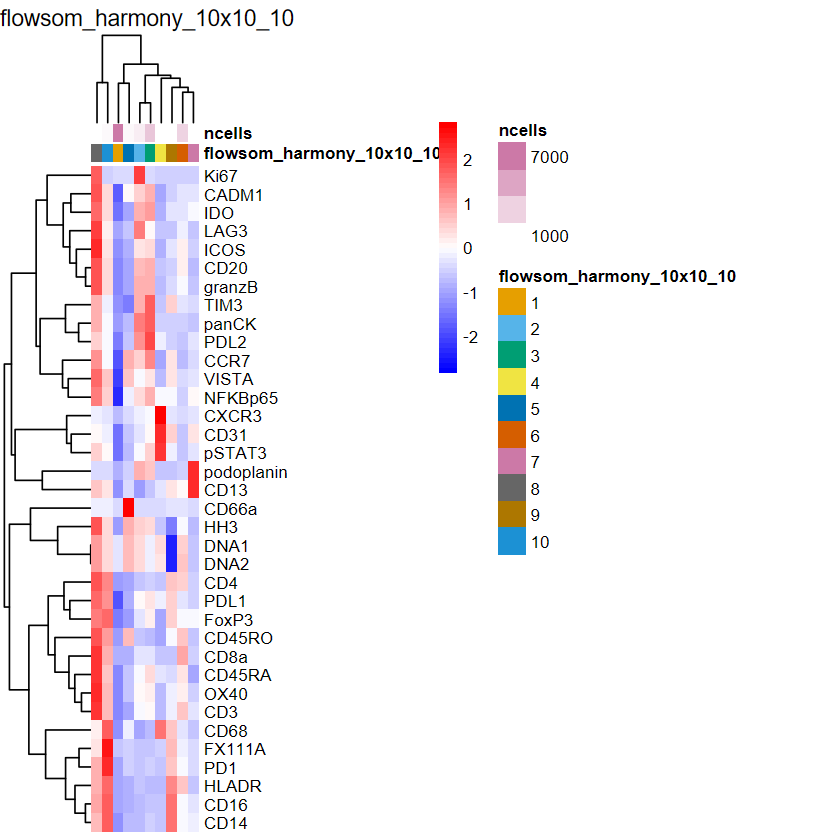

In [ ]:
plot_list[[1]]
# We can see here one main cluster (8)
# of CD8 T cells expressing CD45RA, as well as some activation
# and cytotoxic markers (granzB)

In [42]:
reducedDimNames(spe)

[1] "PCA"                    "UMAP"                   "HARMONY"               
[4] "UMAP_harmony_corrected"

In [ ]:
# We can also try to visualize it on the UMAPs :
cluster_umap <- plot_umap(
  spe,
  by = "colData",
  reducedDim = "UMAP_harmony_corrected"
)

marker_umap <- plot_umap(
  spe,
  by = "marker",
  select = use_channel,
  assay_name = "asinh_transformed"
)

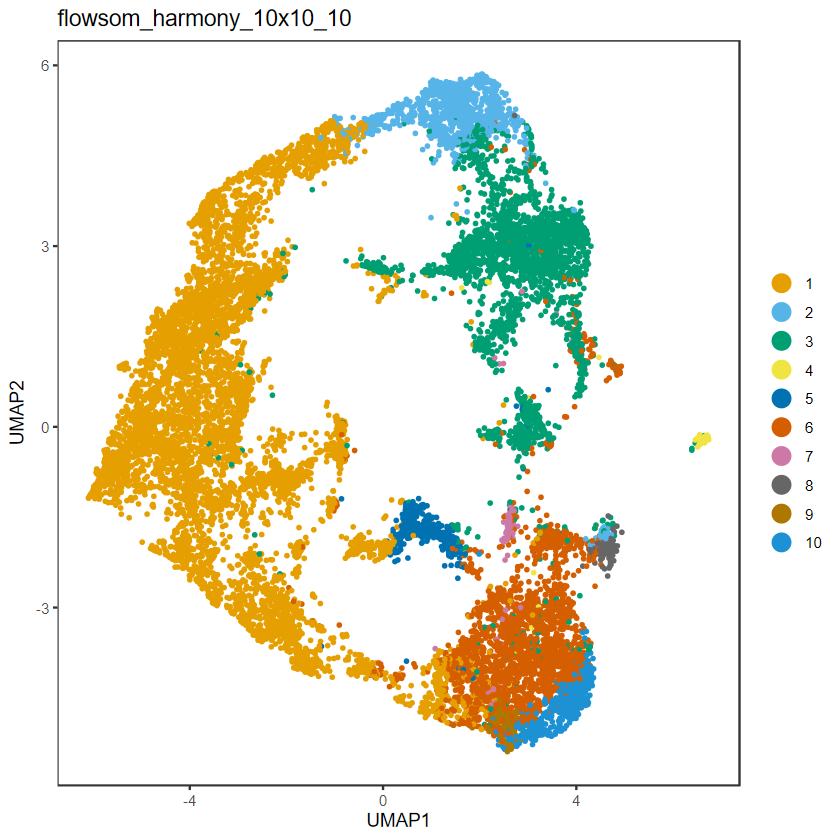

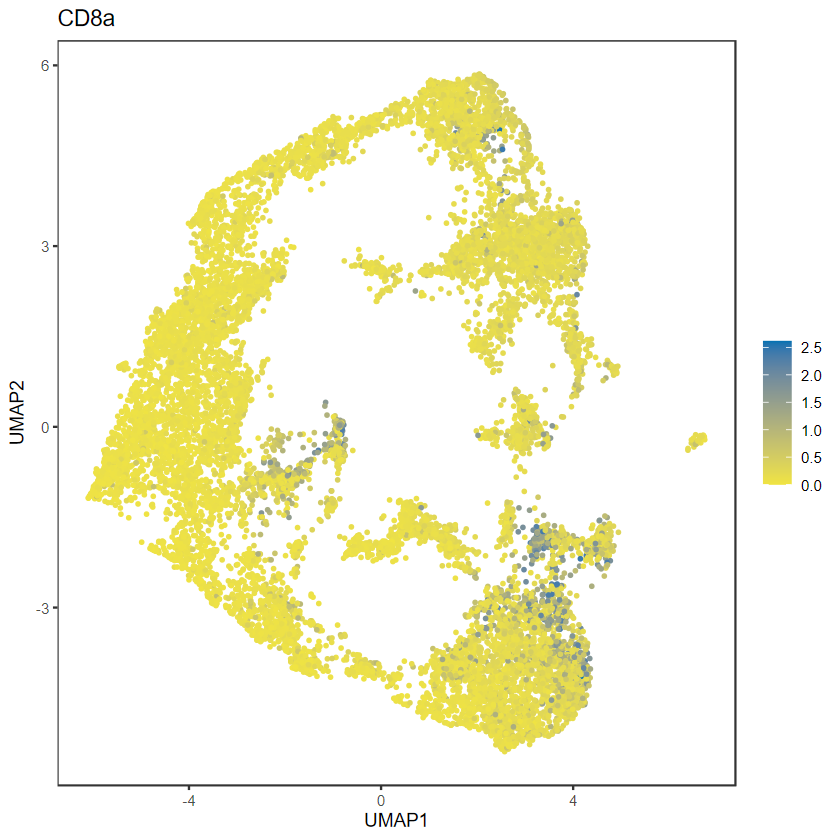

In [ ]:
cluster_umap[[1]]
marker_umap$CD8a
# This shows us how small the cluster 8 is, 
# But it is only located in the CD8 positive area
# We can also see that the cluster 6, which appear low CD8 CD45RO
# May only be partially CD8

# Conclusion

This short example serves to showcase some of the utility of this pipeline. <br>

At this point, the flowsom approach may appear more interesting. After setting the parameters, we would restart from the full object, without downsampling. <br>

As to go forward with spatial analysis, we will need an object that is not downsampled.